In [1]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
#from cftime import datetime 
from datetime import datetime, timedelta
#import datetime as dt
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import sys
import os
import psutil
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
from tqdm import tqdm
from dask.distributed import LocalCluster, Client
import dask.array as da
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar  # Import the ProgressBar class
import calendar
import glob
%matplotlib inline 
#import line_profiler
#%load_ext line_profiler

/tmp/ipykernel_222138/1870643686.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


In [2]:

# Specify the paths for files in June, July, and August
file_pattern_june = 'Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-06-*.nc'
file_pattern_july = 'Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-07-*.nc'
file_pattern_august = 'Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-08-*.nc'

# Open the datasets for June, July, and August
ds_june = xr.open_mfdataset(file_pattern_june)
ds_july = xr.open_mfdataset(file_pattern_july)
ds_august = xr.open_mfdataset(file_pattern_august)

# Concatenate along the time dimension
ds_combined = xr.concat([ds_june, ds_july, ds_august], dim='time')



In [3]:
timee = ds_combined.variables['time']
start_cftime_date = '0001-06-01'
#times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    

lon = ds_combined.variables['lon']
lat = ds_combined.variables['lat']
lev = ds_combined.variables['lev']
dst = ds_combined.transpose("lev", ...)

geopH = dst.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))

temp = dst.variables['T']

#===================================================================================================
elect = dst.variables['e']
Fep = dst.variables['Fep']
Mgp = dst.variables['Mgp']
Nap = dst.variables['Nap']

electav = elect.mean(dim='time')
Fepav = Fep.mean(dim='time')
Mgpav = Mgp.mean(dim='time')
Napav = Nap.mean(dim='time')



In [4]:
altitude_min = 80
altitude_max = 130

max_index = np.argmin(np.abs(Zavg.values - altitude_min))
min_index = np.argmin(np.abs(Zavg.values - altitude_max))

# Slice the array along the altitude dimension
Fep_sliced = Fepav[min_index:max_index + 1,:,:]
Nap_sliced = Napav[min_index:max_index + 1,:,:]
Mgp_sliced = Mgpav[min_index:max_index + 1,:,:]
elect_sliced = electav[min_index:max_index + 1,:,:]

Zavg_sliced = Zavg[min_index:max_index + 1]

M_Factor = ( Nap_sliced + Mgp_sliced + Mgp_sliced + Fep_sliced) / Fep_sliced
e_Factor = elect_sliced / Fep_sliced 

In [8]:
# Specify the desired altitude in km
desired_altitude_km = 100.0

# Find the index of the closest altitude in geopH
closest_altitude_index = np.abs(Zavg_sliced - desired_altitude_km).argmin(dim='lev')

# Use the index to select values from the 'Factor' variable
sel_M_Factor = M_Factor.isel(lev=closest_altitude_index)
sel_e_Factor = e_Factor.isel(lev=closest_altitude_index)



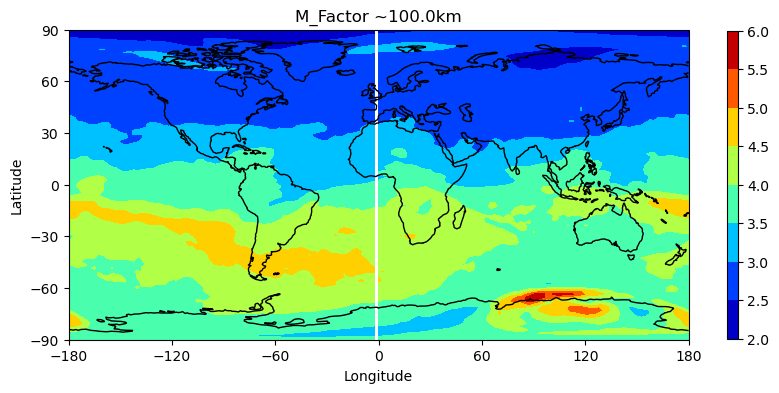

In [9]:

# Create a 2D grid using meshgrid
lon_2d, lat_2d = np.meshgrid(lon, lat)


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lon, lat, sel_M_Factor, cmap='jet'#, levels=np.linspace(0, 0.5, 11)
                      , transform=ccrs.PlateCarree())
cbar = plt.colorbar(contour
                    #, label=''
                    , ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.5)
ax.coastlines()

ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks(np.linspace(-90, 90, 7))
ax.set_ylabel('Latitude')
ax.set_title(f'M_Factor ~{desired_altitude_km}km')

#gl = ax.gridlines(draw_labels=True, linestyle='--')

figname = f'M_Factor_{desired_altitude_km}.png'
plt.savefig('./Figures/Factor/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()

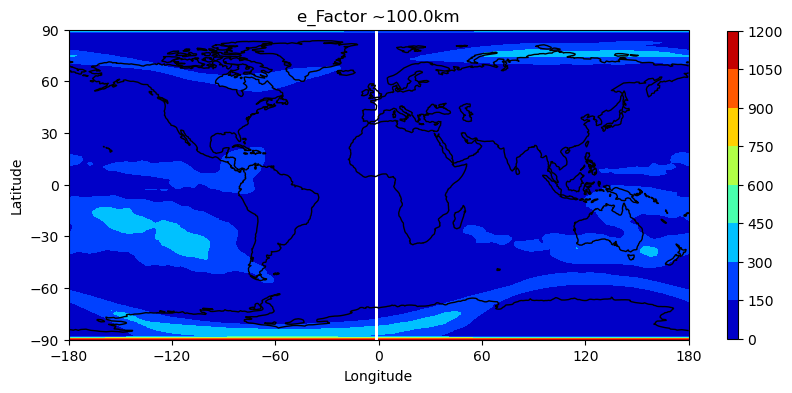

In [11]:

# Create a 2D grid using meshgrid
lon_2d, lat_2d = np.meshgrid(lon, lat)


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lon, lat, sel_e_Factor, cmap='jet'#, levels=np.linspace(0, 0.5, 11)
                      , transform=ccrs.PlateCarree())
cbar = plt.colorbar(contour
                    #, label=''
                    , ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.5)
ax.coastlines()

ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks(np.linspace(-90, 90, 7))
ax.set_ylabel('Latitude')
ax.set_title(f'e_Factor ~{desired_altitude_km}km')

#gl = ax.gridlines(draw_labels=True, linestyle='--')

figname = f'e_Factor_{desired_altitude_km}.png'
plt.savefig('./Figures/Factor/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()